![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

## Equilibrium of a system of weights connected by strings/springs

In this notebook we show how to solve the following problem: Find the equlibrium of a system of masses connected by a system of strings, with some masses being assigned fixed coordinates (attached to the wall, say). See the next picture.

![](basic.png)

Suppose we have $n$ masses with weights $w_1,\ldots,w_n$, and the length of the string between $i$ and $j$ is $\ell_{ij}$ for some set $L$ of pairs of indices $(i,j)$ (we assume $\ell_{ij}$ is not defined if there is no connection). The strings themselves have no mass. We also have a set $F$ of indices such that the $i$-th point is fixed to have coordinates $f_i$ if $i\in F$. The equilibrium of the system is a configuration which minimizes potential energy. With this setup we can write our problem as:

\begin{equation}
\begin{array}{ll}
minimize & g\cdot \sum_i w_ix_i^{(2)} \\
s.t.     & \|x_i-x_j\|\leq \ell_{ij},\ ij\in L \\
         & x_i = f_i,\ i\in F
\end{array}
\end{equation}

where $x\in (\mathbf{R}^n)^2$, $x_i^{(2)}$ denotes the second (vertical) coordinate of $x_i$ and $g$ is the gravitational constant.

Here is a sample problem description.

In [1]:
w = [0.0, 1.1, 2.2, 0.0, 2.1, 2.2, 0.2]
l = {(0,1): 1.0, (1,2): 1.0, (2,3): 1.0, (1,4): 1.0, (4,5): 0.3, (5,2): 1.0, (5,6): 0.5, (1,3): 8.0}
f = {0: (0.0,1.0), 3: (2.0,1.0)}
g = 9.81

Now we can formulate the problem using Mosek Fusion:

In [2]:
from mosek.fusion import *

# w - masses of points
# l - lengths of strings
# f - coordinates of fixed points
# g - gravitational constant
def stringModel(w, l, f, g):
    n, m = len(w), len(l)
    starts = [ lKey[0] for lKey in l.keys() ]
    ends = [ lKey[1] for lKey in l.keys() ]

    M = Model("strings")

    # Coordinates of points
    x = M.variable("x", [n, 2])

    # A is the signed incidence matrix of points and strings
    A = Matrix.sparse(m, n, range(m)+range(m), starts+ends, [1.0]*m+[-1.0]*m)

    # ||x_i-x_j|| <= l_{i,j}
    c = M.constraint("c", Expr.hstack(Expr.constTerm(l.values()), Expr.mul(A, x)), 
        Domain.inQCone() )

    # x_i = f_i for fixed points
    for i in f:
        M.constraint(x.slice([i,0], [i+1,2]), Domain.equalsTo(list(f[i])))

    # sum (g w_i x_i_2)
    M.objective(ObjectiveSense.Minimize, 
        Expr.mul(g, Expr.dot(w, x.slice([0,1], [n,2]))))

    # Solve
    M.solve()
    if M.getProblemStatus(SolutionType.Interior) == ProblemStatus.PrimalAndDualFeasible:
        return x.level().reshape([n,2]), c.dual().reshape([m,3])
    else:
        return None, None


Here is a quick description of how we use vectorization to deal with all the conic constraints in one go. The matrix $A$ is the incidence matrix between the masses and the strings, with coefficients $+1, -1$ for the two endpoints of each string. It is chosen so that the product $Ax$ has rows of the form

$$
(x_i^{(1)} - x_j^{(1)}, x_i^{(2)} - x_j^{(2)})
$$

for all pairs $i,j$ for which $\ell_{ij}$ is bounded. Stacking the values of $\ell$ in the left column produces a matrix with each row of the form

$$
(\ell_{ij}, x_i^{(1)} - x_j^{(1)}, x_i^{(2)} - x_j^{(2)})
$$

and a conic constraint is imposed on all the rows, as required.

The objective and linear constraints show examples of slicing the variable $x$.

The function returns the coordinates of the masses and the values of the dual conic variables. A zero dual value indicates that a particular string is hanging loose, and a nonzero value means it is fully stretched. 

All we need now is to define a display function and we can look at some plots.

In [3]:
%matplotlib inline
# x - coordinates of the points
# c - dual values of string length constraints
# d - pairs of points to connect
def display(x, c, d):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    # Plot points
    ax.scatter(x[:,0], x[:,1], color="r")
    # Plot fully stretched strings (nonzero dual value) as solid lines, else dotted lines
    for i in range(len(c)):
        col = "b" if c[i][0] > 1e-4 else "b--"
        ax.plot([x[d[i][0]][0], x[d[i][1]][0]], [x[d[i][0]][1], x[d[i][1]][1]], col)
    ax.axis("equal")
    plt.show()

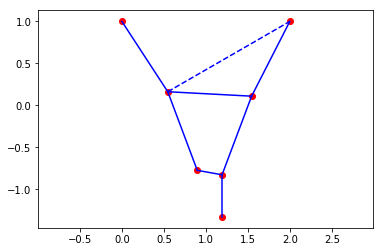

In [4]:
x,c = stringModel(w, l, f, g)

if x is not None:
    display(x, c, l.keys())

How about we find a discrete approximation to the [catenary](#https://en.wikipedia.org/wiki/Catenary):

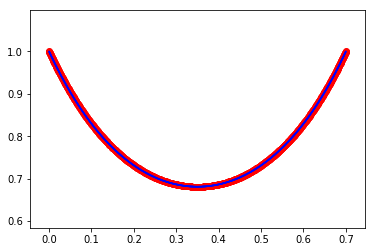

In [5]:
n = 1000
w = [1.0]*n
l = {(i,i+1): 1.0/n for i in range(n-1)}
f = {0: (0.0,1.0), n-1: (0.7,1.0)}
g = 9.81

x,c = stringModel(w, l, f, g)
if x is not None:
    display(x, c, l.keys())

We can also have more suspension points and more complicated shapes:

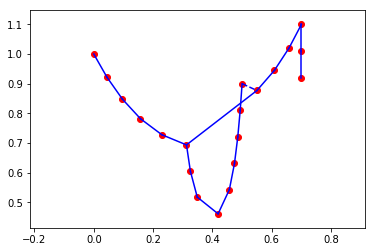

In [6]:
n = 20
w = [1.0]*n
l = {(i,i+1): 0.09 for i in range(n-1)}
l.update({(5,14): 0.3})
f = {0: (0.0,1.0), 13: (0.5,0.9), 17: (0.7,1.1)}
g = 9.81

x,c = stringModel(w, l, f, g)
if x is not None:
    display(x, c, l.keys())

## Duality and feasibility

The dual problem is as follows:

\begin{equation}
\begin{array}{ll}
maximize & -\sum_{ij\in L}\ell_{ij}y_{ij} - \sum_{i\in F}f_i\circ z_i\\
s.t.     & y_{ij}\geq \|v_{ij}\|,\ ij\in L \\
         & \sum_{j~:~ij\in L} v_{ij}\mathrm{sgn}_{ij} + \left(\begin{array}{c}0\\ gw_i\end{array}\right) +z_i = 0, \ i=1,\ldots,n
\end{array}
\end{equation}

where $\mathrm{sgn}_{ij}=+1$ if $i>j$ and $-1$ otherwise and $\circ$ is the dot product. The variables are $(y_{ij},v_{ij})\in \mathbf{R}\times\mathbf{R}^2$ for $ij\in L$ and $z_i\in\mathbf{R}^2$ for $i\in F$ (we assume $z_i=0$ for $i\not\in F$).

Obviously (!) the linear constraints describe the equilibrium of forces at every mass. The ingredients are: the vectors of forces applied through adjacent strings ($v_{ij}$), gravity, and the attaching force holding a fixed point in its position. By proper use of vectorization this is much easier to express in Fusion than it looks:

In [7]:
def dualStringModel(w, l, f, g):
    n, m = len(w), len(l)
    starts = [ lKey[0] for lKey in l.keys() ]
    ends = [ lKey[1] for lKey in l.keys() ]

    M = Model("dual strings")

    x = M.variable(Domain.inQCone(m,3))       #(y,v)
    y = x.slice([0,0],[m,1])
    v = x.slice([0,1],[m,3])
    z = M.variable([n,2])

    # z_i = 0 if i is not fixed
    for i in range(n):
        if i not in f:
            M.constraint(z.slice([i,0], [i+1,2]), Domain.equalsTo(0.0))

    B = Matrix.sparse(m, n, range(m)+range(m), starts+ends, [1.0]*m+[-1.0]*m).transpose()
    w2 = Matrix.sparse(n, 2, range(n), [1]*n, [-wT*g for wT in w])

    # sum(v_ij *sgn(ij)) + z_i = -(0, gw_i) for all vertices i
    M.constraint(Expr.add( Expr.mul(B, v), z ), Domain.equalsTo(w2))

    # Objective -l*y -fM*z
    fM = Matrix.sparse(n, 2, f.keys()+f.keys(), [0]*len(f)+[1]*len(f), 
                       [pt[0] for pt in f.values()] + [pt[1] for pt in f.values()])
    
    M.objective(ObjectiveSense.Maximize, Expr.neg(Expr.add(Expr.dot(l.values(), y),Expr.dot(fM, z))))
    M.solve()

Let us quickly discuss the possible situations regarding feasibility:

* The system has an equilibrium --- the problem is **primal feasible** and **dual feasible**.
* The strings are too short and it is impossible to stretch the required distance between fixed points --- the problem is **primal infeasible**.
* The system has a component that is not connected to any fixed point, hence some masses can keep falling down indefinitely, causing the problem **primal unbounded**. Clearly the forces within such component cannot be balanced, so the problem is **dual infeasible**.

## Springs

We can extend this to consider infinitely strechable springs instead of fixed-length strings connecting the masses. The next model appears in [Applications of SOCP](#http://stanford.edu/~boyd/papers/pdf/socp.pdf) by Lobo, Boyd, Vandenberghe, Lebret. We will now interpret $\ell_{ij}$ as the base length of the spring and assume that the elastic potential energy stored in the spring at length $x$ is 

$$
E_{ij}=\left\{\begin{array}{ll}0 & x\leq \ell_{ij}\\ \frac{k}{2}(x-\ell_{ij})^2 & x>\ell_{ij}\end{array}\right.
$$

That leads us to consider the following second order cone program minimizing the total potential energy:

\begin{equation}
\begin{array}{ll}
minimize & g\cdot \sum_i w_ix_i^{(2)} + \frac{k}{2}\sum_{ij\in L} t_{ij}^2 \\
s.t.     & \|x_i-x_j\|\leq \ell_{ij}+t_{ij},\ ij\in L \\
         & 0\leq t_{ij},\ ij\in L \\
         & x_i = f_i,\ i\in F
\end{array}
\end{equation}

If $t$ denotes the vector of $t_{ij}$ then using a rotated quadratic cone for $(1,T,t)$:

$$
2\cdot 1\cdot T\geq \|t\|^2
$$

will place a bound on $\frac12\sum t_{ij}^2$. We now have a simple extension of the first model.

In [8]:
# w - masses of points
# l - lengths of strings
# f - coordinates of fixed points
# g - gravitational constant
# k - stiffness coefficient
def elasticModel(w, l, f, g, k):
    n, m = len(w), len(l)
    starts = [ lKey[0] for lKey in l.keys() ]
    ends = [ lKey[1] for lKey in l.keys() ]

    M = Model("strings")
    x = M.variable("x", [n, 2])                 # Coordinates
    t = M.variable(m, Domain.greaterThan(0.0))  # Streching

    T = M.variable(1)                           # Upper bound
    M.constraint(Expr.vstack(T, Expr.constTerm(1.0), t), Domain.inRotatedQCone())

    # A is the signed incidence matrix of points and strings
    A = Matrix.sparse(m, n, range(m)+range(m), starts+ends, [1.0]*m+[-1.0]*m)

    # ||x_i-x_j|| <= l_{i,j} + t_{i,j}
    c = M.constraint("c", Expr.hstack(Expr.add(t, Expr.constTerm(l.values())), Expr.mul(A, x)), 
        Domain.inQCone() )

    # x_i = f_i for fixed points
    for i in f:
        M.constraint(x.slice([i,0], [i+1,2]), Domain.equalsTo(list(f[i])))

    # sum (g w_i x_i_2) + k*T
    M.objective(ObjectiveSense.Minimize, 
        Expr.add(Expr.mul(k,T), Expr.mul(g, Expr.dot(w, x.slice([0,1], [n,2])))))

    # Solve
    M.solve()
    if M.getProblemStatus(SolutionType.Interior) == ProblemStatus.PrimalAndDualFeasible:
        return x.level().reshape([n,2]), c.dual().reshape([m,3])
    else:
        return None, None

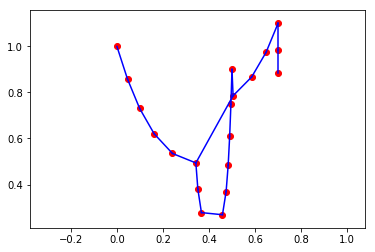

In [9]:
n = 20
w = [1.0]*n
l = {(i,i+1): 0.09 for i in range(n-1)}
l.update({(5,14): 0.3})
f = {0: (0.0,1.0), 13: (0.5,0.9), 17: (0.7,1.1)}
g = 9.81
k = 800

x, c = elasticModel(w, l, f, g, k)
if x is not None:
    display(x, c, l.keys())

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 